# ZIP Code
Normalized handwritten digits, automatically scanned from envelopes by the U.S. Postal Service. The original scanned digits are binary and of different sizes and orientations; the images here have been deslanted and size normalized, resulting in 16 x 16 grayscale images (Le Cun et al., 1990).

The data is in a numpy compressed file, and each row consists of the digit id (0-9) followed by the 256 grayscale values. The last column contains is_test flag 0 for train and 1 for test observations.

There are 7291 training observations and 2007 test observations.

The test set is notoriously "difficult", and a 2.5% error rate is excellent. These data were kindly made available by the neural network group at AT&T research labs (thanks to Yann Le Cunn).

In [1]:
import pandas as pd
from matplotlib import transforms, pyplot as plt
import numpy as np

%matplotlib inline

# define plots common properties and color constants
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY1, GRAY4, GRAY7 = '#231F20', '#646369', '#929497'

## Load and Prepare Data

In [2]:
# load numpy array from the compressed file
arr = np.load('../data/zip.npy.npz')['arr_0']
# do train-test split by the last column
train, test = arr[arr[:, -1] == 0], arr[arr[:, -1] == 1]
X_train, X_test = train[:, 1:-1], test[:, 1:-1]
y_train, y_test = train[:, 0].astype(int), test[:, 0].astype(int)

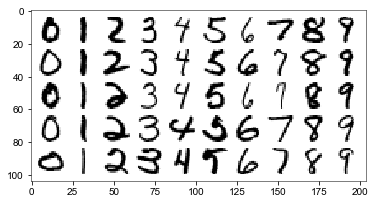

In [3]:
# PAGE 404. FIGURE 11.9. Examples of training cases from ZIP code data. Each
#           image is a 16 × 16 8-bit grayscale representation of a handwritten
#           digit.
w = 20  # pixels for one digit
result = np.ones(shape=(4+w*5, 4+w*10))
for d in range(10):
    d_idx = np.squeeze(np.argwhere(y_train == d))
    d_idx = np.random.choice(d_idx, 5, replace=False)
    for i, idx in enumerate(d_idx):
        result[i*w+4:i*w+20, d*w+4:d*w+20] = -X_train[idx].reshape((16, 16))
_ = plt.imshow(result, cmap="gray")

## Net-1
No hidden layer, equivalent to multinomial logistic regression.

In [4]:
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
import math

tf.logging.set_verbosity(tf.logging.ERROR)

In [5]:
ohe = OneHotEncoder(categories='auto')
Y_train_one_hot = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()
Y_test_one_hot = ohe.fit_transform(y_test.reshape(-1, 1)).toarray()

In [6]:
session = tf.Session()
initializer = tf.contrib.layers.xavier_initializer()
x = tf.placeholder(tf.float64, shape=[None, 256])
y = tf.placeholder(tf.float64, shape=[None, 10])

In [7]:
A = tf.Variable(initializer([256, 10], dtype=tf.float64))
a0 = tf.Variable(initializer([1, 10], dtype=tf.float64))
T = a0 + x @ A
y_hat = tf.nn.softmax(T)
cross_entropy = y*tf.log(y_hat)
loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices = 1))

In [9]:
adm = tf.train.AdamOptimizer(1e-2).minimize(loss)

In [10]:
train_feed_dict = {x: X_train, y: Y_train_one_hot}
test_feed_dict = {x: X_test}

In [89]:
# let's write a generic training procedure 
def train(optimizer_step, fd_train, fd_test):
    accuracy = []
    session.run(tf.global_variables_initializer())
    for e in range(1000):
        session.run(optimizer_step, fd_train)
        y_test_hat = np.argmax(session.run(y_hat, fd_test), axis=1)
        accuracy.append(accuracy_score(y_test, y_test_hat))
        print(e, accuracy[-1])
    return accuracy

In [12]:
accuracy1 = train(adm)

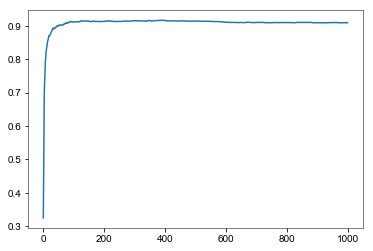

In [13]:
plt.plot(range(1000), accuracy1)

## Net-2
One hidden layer, 12 hidden units fully connected.

In [14]:
n_hidden = 12

A = tf.Variable(initializer([256, n_hidden], dtype=tf.float64))
a0 = tf.Variable(initializer([1, n_hidden], dtype=tf.float64))
B = tf.Variable(initializer([n_hidden, 10], dtype=tf.float64))
b0 = tf.Variable(initializer([10], dtype=tf.float64))

Z = tf.nn.sigmoid(a0 + x@A)
T = b0 + Z@B

y_hat = tf.nn.softmax(T)

cross_entropy = y*tf.log(y_hat)
loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices = 1))
adm = tf.train.AdamOptimizer(1e-2).minimize(loss)

In [15]:
accuracy2 = train(adm)

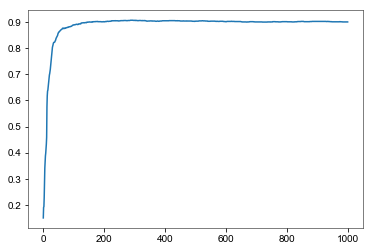

In [16]:
plt.plot(range(1000), accuracy2)

In [122]:
#A = tf.Variable(initializer([8, 8, 3, 3], dtype=tf.float64))
#a0 = tf.Variable(initializer([8, 8], dtype=tf.float64))
X = tf.placeholder(tf.float64, shape=[None, 16, 16])
fd_train = {X: X_train.reshape((X_train.shape[0], 16, 16)), y: Y_train_one_hot}
fd_test = {X: X_test.reshape((X_test.shape[0], 16, 16))}

In [123]:
A = tf.Variable(initializer([8, 8, 9], dtype=tf.float64))
a0 = tf.Variable(initializer([64], dtype=tf.float64))

B = tf.Variable(initializer([4, 4, 9], dtype=tf.float64))
a0 = tf.Variable(initializer([64], dtype=tf.float64))

In [124]:
N = tf.shape(X)[0]
t_arr = []
for i in range(8):
    si, fi = i*2, i*2 + 3
    if i == 7:
        si, fi = si-1, fi-1
    for j in range(8):
        sj, fj = j*2, j*2 + 3
        if j == 7:
            sj, fj = sj-1, fj-1
        t = tf.reshape(X[:,si:fi, sj:fj], [N, 9]) @ tf.reshape(A[i, j, :], [9, 1])
        t_arr.append(t)
t1 = tf.nn.sigmoid(tf.concat(t_arr, axis=1) + a0)

B = tf.Variable(initializer([64, 10], dtype=tf.float64))
b0 = tf.Variable(initializer([10], dtype=tf.float64))

T = b0 + Z@B

y_hat = tf.nn.softmax(T)

cross_entropy = y*tf.log(y_hat)
loss = tf.reduce_mean(-tf.reduce_sum(cross_entropy, reduction_indices = 1))
adm = tf.train.AdamOptimizer(1e-2).minimize(loss)

In [126]:
#session.run(tf.global_variables_initializer())
#session.run(X, fd_train)
accuracy3 = train(adm, fd_train, fd_test)

0 0.2127553562531141
1 0.2700548081714001
2 0.3029397110114599
3 0.30144494270054806
4 0.299451918285999
5 0.2999501743896363
6 0.3034379671150972
7 0.3109118086696562
8 0.34977578475336324
9 0.41953163926258097
10 0.4838066766317887
11 0.510214250124564
12 0.5097159940209267
13 0.5042351768809168
14 0.5082212257100149
15 0.5092177379172895
16 0.5151968111609367
17 0.523168908819133
18 0.523168908819133
19 0.5376183358246138
20 0.5530642750373692
21 0.5809666168410563
22 0.6058794220229198
23 0.6292974588938715
24 0.6512207274539114
25 0.6741405082212257
26 0.6895864474339811
27 0.7035376183358246
28 0.7174887892376681
29 0.7289486796213254
30 0.7354260089686099
31 0.7433981066268062
32 0.7538614848031888
33 0.7603388141504733
34 0.763328350772297
35 0.763328350772297
36 0.7673143996013951
37 0.7698056801195815
38 0.7747882411559541
39 0.7787742899850523
40 0.7832585949177877
41 0.7877428998505231
42 0.7932237169905332
43 0.7962132536123567
44 0.7987045341305431
45 0.8016940707523668
4

369 0.9138016940707524
370 0.9138016940707524
371 0.9138016940707524
372 0.9138016940707524
373 0.9138016940707524
374 0.9138016940707524
375 0.9138016940707524
376 0.9138016940707524
377 0.9138016940707524
378 0.9138016940707524
379 0.9138016940707524
380 0.9138016940707524
381 0.9142999501743896
382 0.9147982062780269
383 0.9147982062780269
384 0.9147982062780269
385 0.9147982062780269
386 0.9147982062780269
387 0.9152964623816642
388 0.9152964623816642
389 0.9152964623816642
390 0.9157947184853015
391 0.9157947184853015
392 0.9157947184853015
393 0.9157947184853015
394 0.9157947184853015
395 0.9157947184853015
396 0.9152964623816642
397 0.9152964623816642
398 0.9152964623816642
399 0.9152964623816642
400 0.9157947184853015
401 0.9157947184853015
402 0.9157947184853015
403 0.9157947184853015
404 0.9157947184853015
405 0.9157947184853015
406 0.9157947184853015
407 0.916791230692576
408 0.916791230692576
409 0.9172894867962132
410 0.9172894867962132
411 0.9172894867962132
412 0.9172894

733 0.9157947184853015
734 0.9157947184853015
735 0.9157947184853015
736 0.9157947184853015
737 0.9157947184853015
738 0.9157947184853015
739 0.9157947184853015
740 0.9157947184853015
741 0.9157947184853015
742 0.9157947184853015
743 0.9162929745889388
744 0.9162929745889388
745 0.9162929745889388
746 0.9162929745889388
747 0.9162929745889388
748 0.9162929745889388
749 0.9162929745889388
750 0.9162929745889388
751 0.9157947184853015
752 0.9157947184853015
753 0.9152964623816642
754 0.9157947184853015
755 0.9157947184853015
756 0.9157947184853015
757 0.9157947184853015
758 0.9157947184853015
759 0.9157947184853015
760 0.9157947184853015
761 0.9157947184853015
762 0.9157947184853015
763 0.9157947184853015
764 0.9157947184853015
765 0.9157947184853015
766 0.9162929745889388
767 0.9162929745889388
768 0.9157947184853015
769 0.9157947184853015
770 0.9157947184853015
771 0.9157947184853015
772 0.9157947184853015
773 0.9157947184853015
774 0.9157947184853015
775 0.9157947184853015
776 0.91529

In [118]:
y_train

array([6, 5, 4, ..., 3, 0, 1])